In [31]:
import gym
import torch
import collections
import matplotlib
import matplotlib.pyplot as plt

import sys
sys.path.append("../environments") 

from tsitsiklis import *

The MDP should obtain a uniform distribution of state visits under its behavioral policy. Or in other words, when following the behavioral policy for some time, all 7 states should receive approximately equal number of visits.

In [32]:
def behavior(env, eps):
    """ Calculates action taken by Baird's counterexample behavioral policy. """
    if float(torch.rand(1)) > eps:
        return 1 # Solid action
    else:
        return 0 # Dashed action

In [33]:
env = gym.make('TsitsiklisVanRoyCounterexample-v0')
env.reset()

states = []
for i in range(10_000):
    action = behavior(env, 0.1)
    state, reward, done, info = env.step(action)
    states += [state]

c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(
c:\Users\m4mou\AppData\Local\Programs\Python\Python312\Lib

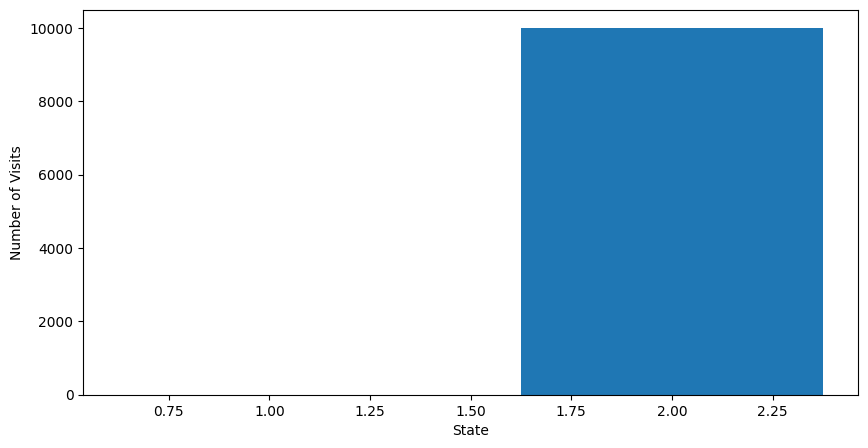

In [34]:
matplotlib.rcParams['figure.figsize'] = [10, 5]

bins = range(1, env.observation_space.n + 1)
plt.hist(states, bins=bins, rwidth=0.75, align='left')

plt.xlabel("State")
plt.ylabel("Number of Visits")

plt.show()

### Divergence of Q-learning with Function Approximation on Baird's Counterexample MDP

Demonstration of instability on Baird's counterexample MDP. The chart shows evolution of
the components of the parameter vector $\boldsymbol{w}$. The step size was $\alpha = 0.05$.
For each action the Q-value weights vector $\boldsymbol{w}$ was initialized in exactly the
same way as in Figure 11.2. Experimentation showed that initialization doesn't have a
qualitative effect on the divergence.

In [54]:
def approximate_q_learning(env, n_steps, gamma = 0.99, alpha = 0.05):
    """ Optimizes weights vector using Q-learning with function approximation.

    The function uses the following version of the Q-learning 
    algorithm with linear function approximation:
        0. Initialize weights to a small random value.
        1. Sample state, action, reward and next_state
        2. Calculate Q target estimate using reward, next_state
           and maximal next action.
        3. Calculate Q value estimate and it's gradient for the
           state and taken action.
        4. Update weights so the Q value for the state and taken
           action to be closer to target.
        5. Goto 1, unless the terminal condition is met.
    """
    assert type(env.observation_space) == gym.spaces.Discrete
    assert type(env.action_space) == gym.spaces.Discrete
    assert env.observation_space.n == 3
    assert env.action_space.n == 2

    features = torch.tensor(
        [
            [1],  # Upper state 1
            [2],  # Upper state 2
            [0],  # Lower state
        ],
        dtype=torch.float,
        requires_grad=False
    )
    weights = torch.randn((1), requires_grad=True)


    def q(state, action):
        """ Calculates approxiate Q value for the specified state and action. """
        nonlocal weights, features
        return features[state] @ weights

    def q_update(state, action, reward, next_state):
        """ Updates the weights vector using the Q-learning rule with AD gradient. """
        nonlocal weights

        q_value = q(state, action)
        q_target = reward + gamma * torch.max(q(next_state, 0), q(next_state, 1))
        delta = q_target - q_value

        q_value.backward()
        with torch.no_grad():
            weights += alpha * delta * weights.grad
            weights.grad.zero_()

    step = 1
    done = False
    history0, history1 = [], []
    state = env.reset()

    while step < n_steps:
        action = behavior(env,1)

        next_state, reward, done, info = env.step(action)
        q_update(state, action, reward, next_state)
        
        state = next_state
        step += 1
        
        history0 += [weights[0].detach().numpy().copy()]
        if done:
            env.reset()

    return history0


In [55]:
env = gym.make('TsitsiklisVanRoyCounterexample-v0')
history = approximate_q_learning(env, n_steps=10000, gamma=0.99, alpha=0.5)
history

[array(-0.37659666, dtype=float32),
 array(-0.36906472, dtype=float32),
 array(-0.36168346, dtype=float32),
 array(-0.35444978, dtype=float32),
 array(-0.34736082, dtype=float32),
 array(-0.3404136, dtype=float32),
 array(-0.33360532, dtype=float32),
 array(-0.32693323, dtype=float32),
 array(-0.3203946, dtype=float32),
 array(-0.31398675, dtype=float32),
 array(-0.30770704, dtype=float32),
 array(-0.30155292, dtype=float32),
 array(-0.2955219, dtype=float32),
 array(-0.28961143, dtype=float32),
 array(-0.28381923, dtype=float32),
 array(-0.27814284, dtype=float32),
 array(-0.27258, dtype=float32),
 array(-0.26712838, dtype=float32),
 array(-0.26178584, dtype=float32),
 array(-0.2565501, dtype=float32),
 array(-0.2514191, dtype=float32),
 array(-0.24639073, dtype=float32),
 array(-0.24146292, dtype=float32),
 array(-0.23663366, dtype=float32),
 array(-0.23190099, dtype=float32),
 array(-0.22726297, dtype=float32),
 array(-0.22271773, dtype=float32),
 array(-0.21826339, dtype=float32),


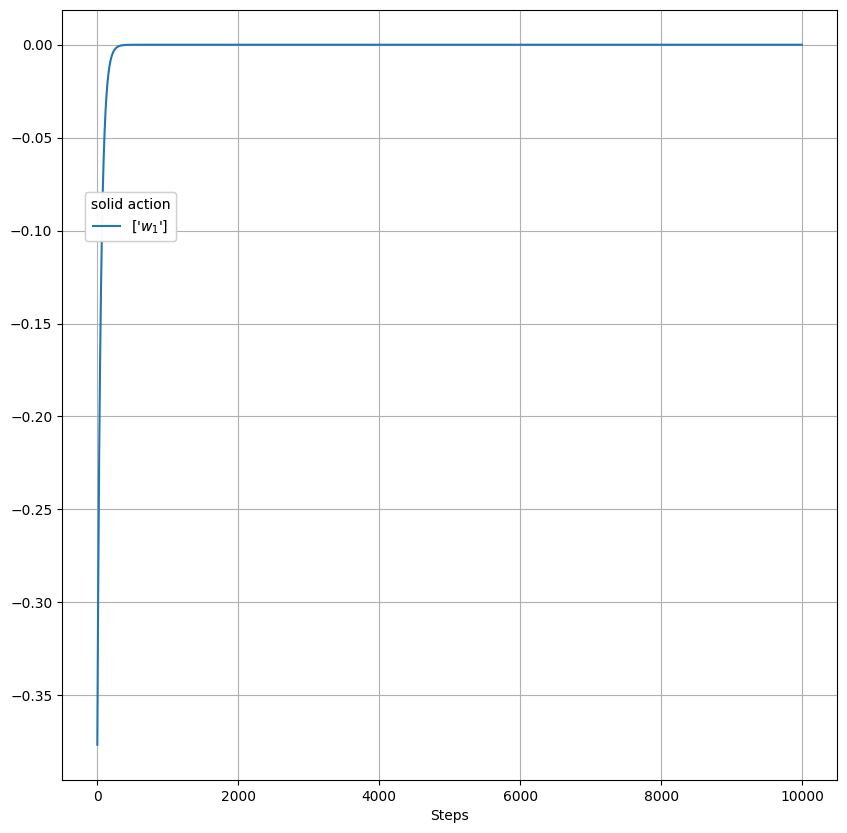

In [56]:
matplotlib.rcParams['figure.figsize'] = [10, 10]

labels = [f"$w_{i+1}$" for i in range(1)]

plt.gca().set_prop_cycle(None)
solid_lines = plt.plot(history, linestyle='-', label=labels)

solid_legend = plt.legend(handles=solid_lines, title='solid action', loc=[0.03, 0.7])
plt.gca().add_artist(solid_legend)

plt.grid(True)
plt.xlabel("Steps")

plt.show()